Include all the packages needed for this exercise as reported below

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import math 
import statsmodels.api as sm
import sklearn
from sklearn.neighbors import KernelDensity
from scipy.integrate import nquad

Welcome to JupyROOT 6.14/06


Define two classes where one defines the caracteristics of a sample (name, name of file and cross-section), the other defines which setup to be fitted (center of the ellipse, radius or both) 

In [2]:
class Sample:
    def __init__(self, name, file, xs):
        self.name = name
        self.file = file
        self.xs = xs
        
class FitSetup:
    x0y0 = 1
    ab = 2
    x0y0ab = x0y0 + ab

In [3]:
#path = "/gpfs/ddn/cms/user/cmsdas/2019/hh_bbtautau/eventTuples/"
path = "/Users/Tita/Desktop/files_school/"
#path = "/Volumes/Silver/cms-das-2019/hh_bbtautau/eventTuples/"

sample_list = [
    Sample("Signal", "ggHH_SM.root", 0.03353 * 2 * 5.809e-01 * 6.256e-02),
    Sample("TT", "TT.root", 831.76)
]

samples = {}
for sample in sample_list:
    samples[sample.name] = sample
    
    file = ROOT.TFile.Open(path+sample.file)
    summary = file.Get("summary")
    sample.total_weight = 0
    for entry in summary:
        sample.total_weight += entry.totalShapeWeight
    
    tauTau = file.Get("tauTau")
    sample.events = np.zeros((tauTau.GetEntries(), 3))
    
    n = 0
    for event in tauTau :
        bb_cand = event.jets_p4[0] + event.jets_p4[1]
        sample.events[n, 0] = bb_cand.mass()
        sample.events[n, 1] = event.SVfit_p4.mass()
        sample.events[n, 2] = event.weight_total
        n += 1

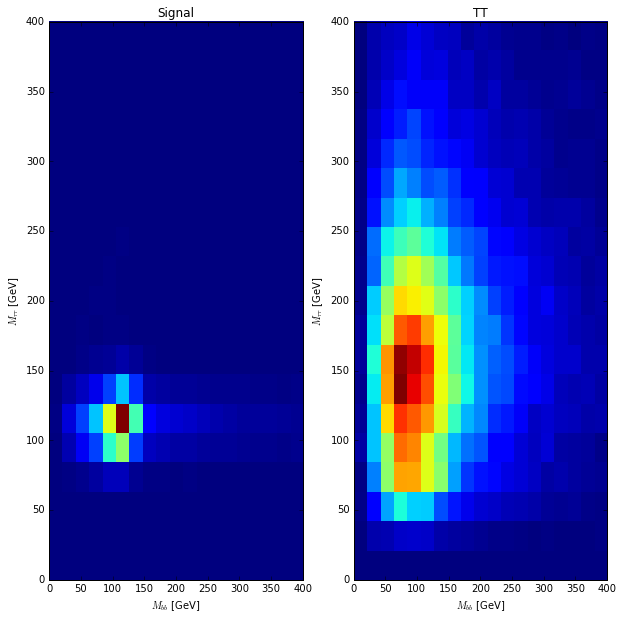

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

n = 0
bins_x = np.linspace(0, 400, 20)
bins_y = np.linspace(0, 400, 20)
for sample in sample_list:
    ax[n].hist2d(sample.events[:, 0], sample.events[:, 1], weights=sample.events[:, 2], bins=[bins_x, bins_y])
    ax[n].set_xlabel(r'$M_{bb}$ [GeV]')
    ax[n].set_ylabel(r'$M_{\tau\tau}$ [GeV]')
    ax[n].set_title(sample.name)
    
    n += 1
#plt.subplots_adjust(bottom=0.1, right=1.5, top=1.5)
plt.show()

In [5]:
class EllipseMinimization( ROOT.TPyMultiGenFunction ):
    def __init__( self, samples, x0, y0, a, b, fit_setup):
        self.samples = samples
        self.x0 = x0
        self.y0 = y0
        self.a = a
        self.b = b
        self.fit_setup = fit_setup
        ROOT.TPyMultiGenFunction.__init__( self, self )

    def NDim(self):
        if self.fit_setup == FitSetup.x0y0ab:
            return 4
        return 2

    def DoEval(self, args):
        n = 0
        x0 = self.x0
        y0 = self.y0
        a = self.a
        b = self.b

        if self.fit_setup & FitSetup.x0y0 != 0:
            x0 = args[0]
            y0 = args[1]
            n = 2
        if self.fit_setup & FitSetup.ab != 0:
            a = args[n]
            b = args[n+1]
        
        n_signal = self.CalcNumEvents('Signal', x0, y0, a, b)
        n_bkg = self.CalcNumEvents('TT', x0, y0, a, b)
        
        #target = -n_signal / math.sqrt(n_bkg) # better formula
        #Discovery sensitivity for a counting experiment with background uncertainty
        #target = math.sqrt(2*((n_signal+n_bkg)*math.log(1 + (n_signal/n_bkg)) - n_signal))
        target = -n_signal/math.sqrt(n_signal+n_bkg)
        #print("target = ", target)
        return target
        
    def CalcNumEvents(self, sample_name, x0, y0, a, b):
        sample = self.samples[sample_name]
        x = sample.events[:, 0]
        y = sample.events[:, 1]
        weight = sample.events[:, 2]
        inside_ellipse = ((x - x0) / a)**2 + ((y - y0) / b) ** 2 < 1
        n_inside = np.sum(inside_ellipse * weight)
        return n_inside / sample.total_weight * sample.xs

In [6]:
def FindParams(samples, x0, y0, a, b, fit_setup):
    minimizer = ROOT.Math.Factory.CreateMinimizer("Minuit", "Combined")
    minimizer.SetTolerance(0.05)
    minimizer.SetPrintLevel(2)
    minimizer.SetStrategy(2)
    ellipse = EllipseMinimization(samples, x0, y0, a, b, fit_setup)

    minimizer.SetFunction(ellipse)

    # Set the variables to be minimized!
    c_factor = 0.1
    r_factor = 5.0
    n = 0
    if fit_setup & FitSetup.x0y0 != 0:
        minimizer.SetLimitedVariable(0, "x0", x0, 1, x0 * (1 - c_factor), x0 * (1 + c_factor))
        minimizer.SetLimitedVariable(1, "y0", y0, 1, y0 * (1 - c_factor), y0 * (1 + c_factor))
        n = 2
    if fit_setup & FitSetup.ab != 0:
        minimizer.SetLimitedVariable(n, "a", a, 0.1, max(2, a * (1 - r_factor)), a * (1 + r_factor))
        minimizer.SetLimitedVariable(n + 1, "b", b, 0.1, max(2, b * (1 - r_factor)), b * (1 + r_factor))
        
    minimizer.Minimize()
    #result = [x for ix in minimizer.X()]
    result = [minimizer.X()[i] for i in range(ellipse.NDim())]
    return tuple(result)

In [7]:
sgn = samples["Signal"].events
hist, bin_edges = np.histogram(sgn[:, 0], bins=200, range=(0, 200))
max_bin = np.argmax(hist)
x0 = (bin_edges[max_bin] + bin_edges[max_bin + 1]) / 2
hist, bin_edges = np.histogram(sgn[:, 1], bins=200, range=(0, 200))
max_bin = np.argmax(hist)
y0 = (bin_edges[max_bin] + bin_edges[max_bin + 1]) / 2
print(x0, y0)

(118.5, 114.5)


In [10]:
interval = np.percentile(sgn[:, 0], [25, 75])
a = max(x0 - interval[0], interval[1] - x0)
interval = np.percentile(sgn[:, 1], [25, 75])
b = max(y0 - interval[0], interval[1] - y0)
print(a, b)

(21.621261596679688, 12.563461303710938)


In [11]:
new_x0, new_y0 = FindParams(samples, x0, y0, a, b, FitSetup.x0y0)
print(new_x0, new_y0)

(115.29073588368594, 111.88941639159708)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 x0           1.18500e+02  1.00000e+00    1.06650e+02  1.30350e+02
     2 y0           1.14500e+02  1.00000e+00    1.03050e+02  1.25950e+02
 **********
 **    3 **SET ERR           1
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           2
 **********
 NOW USING STRATEGY  2: MAKE SURE MINIMUM TRUE, ERRORS CORRECT  
 **********
 **    6 **MIGRAD           0        0.05
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  2.  CONVERGENCE WHEN EDM .LT. 5.00e-05
 COVARIANCE MATRIX CALCULATED SUCCESSFULLY
 FCN=-0.000259417 FROM HESSE     STATUS=OK             22 CALLS          23 TOTAL
                     EDM=6.01064e-06    STRATEGY= 2      ERROR MAT

In [12]:
new_a, new_b = FindParams(samples, new_x0, new_y0, a, b, FitSetup.ab)
print(new_a, new_b)

(33.52660832565479, 25.579432875015133)
 **********
 **    7 **SET PRINT           1
 **********
 **********
 **    8 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 a            2.16213e+01  1.00000e-01    2.00000e+00  1.29728e+02
     2 b            1.25635e+01  1.00000e-01    2.00000e+00  7.53808e+01
 **********
 **    9 **SET ERR           1
 **********
 **********
 **   10 **SET PRINT           1
 **********
 **********
 **   11 **SET STR           2
 **********
 NOW USING STRATEGY  2: MAKE SURE MINIMUM TRUE, ERRORS CORRECT  
 **********
 **   12 **MIGRAD           0        0.05
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  2.  CONVERGENCE WHEN EDM .LT. 5.00e-05
 COVARIANCE MATRIX CALCULATED SUCCESSFULLY
 FCN=-0.000265102 FROM HESSE     STATUS=OK             24 CALLS          25 TOTAL
                     EDM=9.88162e-05    STRATEGY= 2      ERROR MATR

In [13]:
final_x0, final_y0, final_a, final_b = FindParams(samples, new_x0, new_y0, new_a, new_b, FitSetup.x0y0ab)
print(new_x0, new_y0, new_a, new_b)
print(final_x0, final_y0, final_a, final_b)

(115.29073588368594, 111.88941639159708, 33.52660832565479, 25.579432875015133)
(114.30635077997704, 110.95172112255295, 34.08965223952416, 24.61645917110062)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 x0           1.15291e+02  1.00000e+00    1.03762e+02  1.26820e+02
     2 y0           1.11889e+02  1.00000e+00    1.00700e+02  1.23078e+02
     3 a            3.35266e+01  1.00000e-01    2.00000e+00  2.01160e+02
     4 b            2.55794e+01  1.00000e-01    2.00000e+00  1.53477e+02
 **********
 **    3 **SET ERR           1
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           2
 **********
 NOW USING STRATEGY  2: MAKE SURE MINIMUM TRUE, ERRORS CORRECT  
 **********
 **    6 **MIGRAD           0        0.05
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 STAR